In [1]:
import pandas as pd
df = pd.read_csv('dataset_case_study.csv')

In [2]:
import numpy as np
df['creation_date'] = pd.to_datetime(df['creation_date'])
# Now calculate days since first creation
df['days_since_first'] = (df['creation_date'] - df['creation_date'].min()).dt.days
df.drop(columns='creation_date',inplace=True)

df['price_per_night']=df['price_euro']/(df['length_of_stay']+1)

df['credit_card_id_count'] = df.groupby('credit_card_id')['credit_card_id'].transform('count')
df['ip_id_count'] = df.groupby('ip_id')['ip_id'].transform('count')
df['email_id_count'] = df.groupby('email_id')['email_id'].transform('count')
df['hotel_id_count'] = df.groupby('hotel_id')['hotel_id'].transform('count')

lang_to_country = {
    'German': 'Germany',
    'Icelandic': 'Iceland', 
    'Slovak': 'Slovakia',
    'Spanish': 'Spain',
    'Norwegian': 'Norway',
    'Luxembourgish': 'Luxembourg',
    'Hungarian': 'Hungary',
    'Italian': 'Italy',
    'Danish': 'Denmark',
    'Swedish': 'Sweden',
    'French': 'France', 
    'Dutch': 'Netherlands',
    'Finnish': 'Finland',
    'Bulgarian': 'Bulgaria',
    'Maltese': 'Malta'}
df['language']=df['language'].map(lang_to_country)

df['language_flag1']=np.where(df['card_issuing_country']!=df['language'],1,0)
df['language_flag2']=np.where(df['card_issuing_country']!=df['booker_country'],1,0)
df['language_flag3']=np.where(df['language']!=df['booker_country'],1,0)

In [3]:
df_model=df.sort_values(by=['days_since_first'],ignore_index=True)
df_model['auth_result']=df_model['auth_result'].map({'AUTHORISED':0, 'INSUFFICIENT_FUNDS_OR_LIMIT_EXCEEDED':0, 'ERROR':0, 'FRAUD':1,'REFUSED':1})

df_model.drop(columns=['price_euro','booker_country', 'card_issuing_country', 'hotel_country', 'language','transaction_id','ip_id','credit_card_id','hotel_id','email_id','days_since_first'],inplace=True)
#df_model.head()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [5]:
def plot_result(y_test, y_pred_prob):
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    import matplotlib.pyplot as plt
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)  
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate (recall)')
    plt.legend()
    
    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    avg_precision = average_precision_score(y_test, y_pred_prob)
    # Plot Precision-Recall curve
    plt.subplot(1,2,2)
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.legend()

In [7]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
def get_evaluation(y,anomaly_score):
        fpr, tpr, thresholds = roc_curve(y,anomaly_score)
        roc_auc = auc(fpr, tpr)
        if roc_auc<0.5:
            anomaly_score=-anomaly_score
            
        fpr, tpr, thresholds = roc_curve(y,anomaly_score)
        roc_auc = auc(fpr, tpr)
        precision, recall, thresholds = precision_recall_curve(y,anomaly_score)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
        best_index = np.argmax(f1_scores)
        best_f1 = f1_scores[best_index]
        best_precision = precision[best_index]
        best_recall = recall[best_index]
        avg_precision = average_precision_score(y,anomaly_score)
        
        a=[best_f1.item(),best_precision.item(),best_recall.item(),avg_precision,roc_auc]
        return a

In [6]:
categorical=['email_domain','payment_method','language_flag1','language_flag2','language_flag3']
numeric=['book_window','length_of_stay','property_age','price_per_night','ip_id_count','credit_card_id_count','email_id_count','hotel_id_count']

y = df_model['auth_result']
X = df_model.drop('auth_result', axis=1)

frac = int(len(X) * 0.9)
#X_train, X_test, y_train, y_test = X.iloc[:frac], X.iloc[frac:], y.iloc[:frac], y.iloc[frac:]
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2,stratify=y)

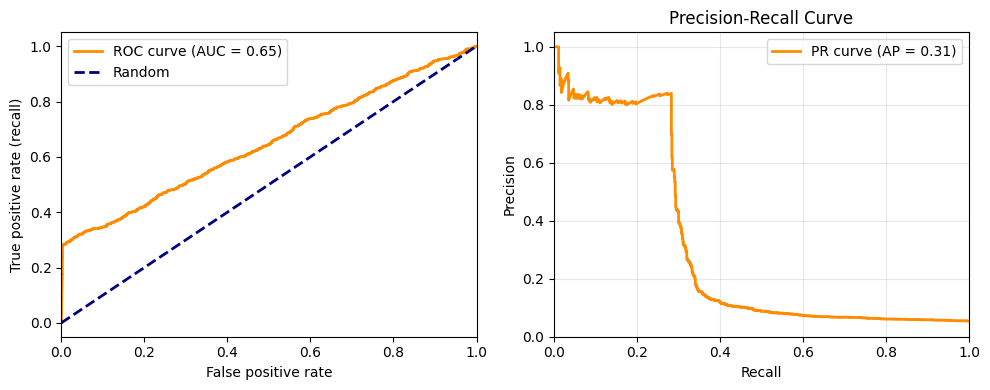

In [8]:
preprocessor=ColumnTransformer(transformers=[
        ('num',StandardScaler(),numeric),
        ('cat',OneHotEncoder(drop='first'),categorical)
        ],remainder='drop')

pipeline=Pipeline([
    ('prep', preprocessor),
    ('clf',LogisticRegression(class_weight='balanced',max_iter=1000))])

pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
#print(classification_report(y_test,y_pred))
plot_result(y_test, y_pred_prob)

In [10]:
a=get_evaluation(y_test,y_pred_prob)
a

[0.4235090748171029,
 0.839041095890411,
 0.2832369942196532,
 0.3089554428511596,
 0.6493210675912967]

In [13]:
df_result = pd.read_csv('result_unsupervised.csv', index_col=0)
df_result

,f1-score,precision,recall,roc-auc,auc
book_window,0.38,0.54,0.29,0.23,0.64
length_of_stay,0.27,0.25,0.28,0.15,0.63
property_age,0.43,0.84,0.29,0.31,0.65
credit_card_id_count,0.43,0.84,0.29,0.28,0.64
ip_id_count,0.38,0.53,0.29,0.17,0.64
email_id_count,0.42,0.77,0.29,0.27,0.64
hotel_id_count,0.42,0.77,0.29,0.30,0.65
language_flag1,0.18,0.12,0.41,0.08,0.62
language_flag2,0.23,0.17,0.35,0.09,0.63
language_flag3,0.23,0.17,0.36,0.10,0.63


In [14]:
df_result=df_result.T
df_result['logistic_regression']=a

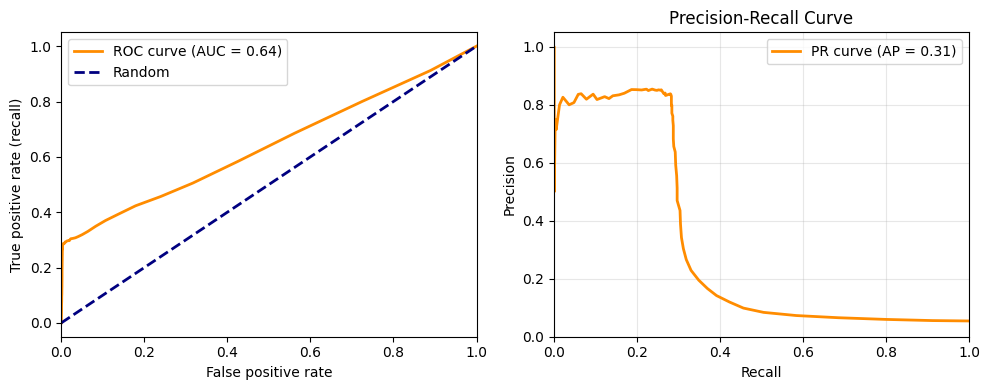

In [15]:
from sklearn.ensemble import RandomForestClassifier
pipeline2=Pipeline([
    ('prep', preprocessor),
    ('clf',RandomForestClassifier(n_estimators=100, random_state = 1,class_weight='balanced'))])
pipeline2.fit(X_train,y_train)
y_pred_prob2 = pipeline2.predict_proba(X_test)[:, 1]
y_pred2=pipeline2.predict(X_test)
#print(classification_report(y_test,y_pred))
a2=get_evaluation(y_test,y_pred_prob2)
df_result['random_forest_classifier']=a2
plot_result(y_test, y_pred_prob2)

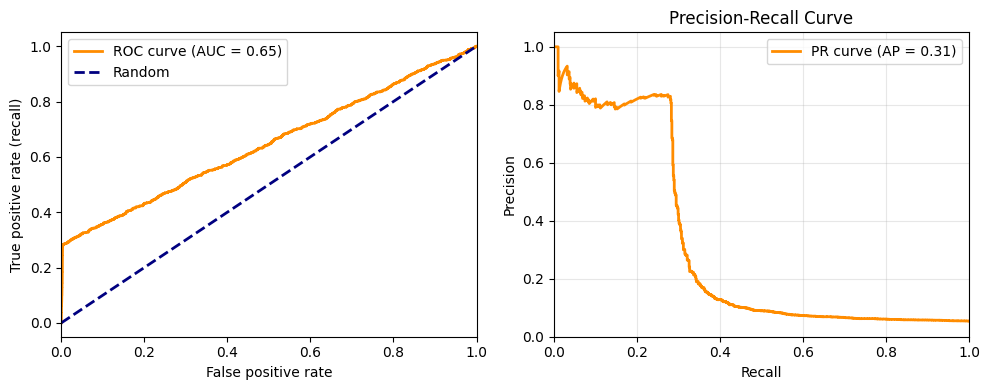

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
pipeline3=Pipeline([
    ('prep', preprocessor),
    ('clf',GradientBoostingClassifier(n_estimators=500, random_state = 1))])
pipeline3.fit(X_train,y_train)
y_pred_prob3 = pipeline3.predict_proba(X_test)[:, 1]
y_pred3=pipeline3.predict(X_test)
#print(classification_report(y_test,y_pred))
a3=get_evaluation(y_test,y_pred_prob3)
df_result['gradient_boosting_classifier']=a3
plot_result(y_test, y_pred_prob3)

In [20]:
df_result.T.round(2)

,f1-score,precision,recall,roc-auc,auc
book_window,0.38,0.54,0.29,0.23,0.64
length_of_stay,0.27,0.25,0.28,0.15,0.63
property_age,0.43,0.84,0.29,0.31,0.65
credit_card_id_count,0.43,0.84,0.29,0.28,0.64
ip_id_count,0.38,0.53,0.29,0.17,0.64
email_id_count,0.42,0.77,0.29,0.27,0.64
hotel_id_count,0.42,0.77,0.29,0.30,0.65
language_flag1,0.18,0.12,0.41,0.08,0.62
language_flag2,0.23,0.17,0.35,0.09,0.63
language_flag3,0.23,0.17,0.36,0.10,0.63


In [21]:
df_result.T.round(2).to_csv('result_supervised.csv')